# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following  algorithms: **Decision Tree**, **Random Forest** and **Gradient Boosted Tree**, i.e. a total of 3 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



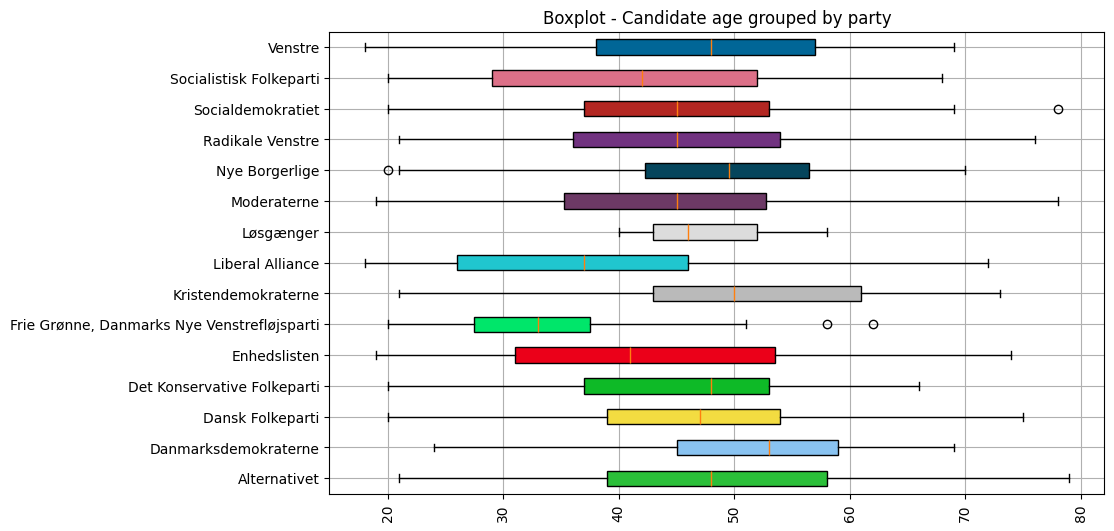

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Opretter en dictionary med farver til hvert parti (til brug i boxplot-visualisering)
# Formålet er at gøre det lettere at skelne partier i plottet
parties_w_color = {
    "Socialdemokratiet" : "#B32722",
    "Radikale Venstre" : "#713280",
    "Det Konservative Folkeparti" : "#0EBA27",
    "Nye Borgerlige" : "#05455C",
    "Socialistisk Folkeparti" : "#DC7088",
    "Liberal Alliance" : "#20C6CF",
    "Kristendemokraterne" : "#BABABA",
    "Moderaterne" : "#6C3965",
    "Dansk Folkeparti" : "#F3DC41",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti" : "#00E66A",
    "Venstre" : "#016697",
    "Danmarksdemokraterne" : "#89C3F1",
    "Enhedslisten" : "#EB0019",
    "Alternativet" : "#2BBF39",
    "Løsgænger" : "#dcdcdc"
}

# Indlæser Excel-datasættet med alle kandidater
alldata = pd.read_excel("alldata.xlsx")

# Fjerner rækker hvor alder er NaN eller 0 (disse vil forstyrre analysen)
alldata_clean = alldata[alldata["alder"] > 0]

# Finder unikke partinavne og sorterer dem alfabetisk
sorted_parties = sorted(alldata_clean["parti"].unique())

# Laver en liste med én serie pr. parti – bruges til at fodre boxplot
# Hver serie indeholder alderen for alle kandidater i det givne parti
data_by_party = [alldata_clean[alldata_clean["parti"] == parti]["alder"].dropna() for parti in sorted_parties]

# Opretter selve boxplottet med farvekodning
plt.figure(figsize=(10, 6))
box = plt.boxplot(data_by_party, patch_artist=True, tick_labels=sorted_parties, vert=False)

# Farver boksene i plottet ud fra farveskemaet for partierne
for patch, party in zip(box['boxes'], sorted_parties):
    color = parties_w_color.get(party, "#111111")
    patch.set_facecolor(color)

# Sætter titel og layout
plt.title('Boxplot - Candidate age grouped by party')
plt.suptitle("")  # Fjerner automatisk undertitel fra matplotlib
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### Analyse: Aldersfordeling blandt kandidater per parti

Dette boxplot viser fordelingen af kandidatalder i hvert parti.

#### Yngste kandidater:
- *Frie Grønne* og *Liberal Alliance* har de laveste medianaldre (omkring 30–35 år).
- Deres fordelinger er også relativt smalle → de fleste kandidater er unge.

#### Ældste kandidater:
- *Kristendemokraterne*, *Danmarksdemokraterne* og *Alternativet* har medianaldre over 50 år.
- *Kristendemokraterne* har en markant høj aldersprofil og få unge kandidater.

#### Bred aldersspredning:
- *Enhedslisten*, *Socialistisk Folkeparti* og *Venstre* har bredt fordelte kandidataldre.
- Det kan indikere diversitet i partiets rekruttering eller opstillingsproces.

#### Outliers:
- Fx én meget ung kandidat hos *Nye Borgerlige*, og en ældre hos *Socialdemokratiet*.
- Disse afviger fra partiets generelle tendens og vises som prikker.

---

#### Konklusion:
Partierne adskiller sig tydeligt i deres aldersprofiler. Nogle har et klart ungt fokus, mens andre repræsenterer en ældre kandidatbase. Der er stor variation både mellem og inden for partier, hvilket understøtter behovet for visuelle analyser som denne.


In [2]:
# Definerer hvilke kolonner der IKKE er holdningsspørgsmål (dem vil vi ikke analysere)
candidate_info_cols = ['navn', 'parti', 'storkreds', 'alder']

# Starter med alle kolonner
question_cols = list(alldata.columns)

# Fjerner kandidatens stamdata fra analysekolonnerne
for col in candidate_info_cols:
    question_cols.remove(col)

# Finder "ekstreme" svar for hver kandidat – altså -2 og +2 på skalaen
# Resultatet bliver en liste for hver række, hvor True betyder ekstremt svar
alldata['extreme_count'] = alldata[question_cols].apply(lambda row: sum(row.isin([-2, 2])), axis=1)

# Regner andelen af ekstreme svar pr. kandidat
alldata['extreme_ratio'] = alldata['extreme_count'] / len(question_cols)

# Finder de 10 mest “konsekvente” eller “selvsikre” kandidater
most_confident_candidates = alldata[['navn', 'parti', 'extreme_ratio']] \
                            .sort_values(by='extreme_ratio', ascending=False) \
                            .head(10)

# Udskriver resultatet
print(most_confident_candidates)

                    navn                                        parti  \
505         Sarah Nørris                                 Enhedslisten   
88         Søren Vanting                  Det Konservative Folkeparti   
559  Kim Andkjær Doberck                               Nye Borgerlige   
44     Mohamed Abdikarim  Frie Grønne, Danmarks Nye Venstrefløjsparti   
152           Rashid Ali  Frie Grønne, Danmarks Nye Venstrefløjsparti   
503          Jan Filbært                                 Enhedslisten   
437  Lone Vase Langballe                             Dansk Folkeparti   
284           John Bjerg                               Nye Borgerlige   
359       Frank Sørensen                             Dansk Folkeparti   
151     Elise Bjerkrheim  Frie Grønne, Danmarks Nye Venstrefløjsparti   

     extreme_ratio  
505       1.000000  
88        1.000000  
559       0.897959  
44        0.877551  
152       0.877551  
503       0.857143  
437       0.857143  
284       0.857143  
359    

### Analyse: De mest “selvsikre” kandidater
Denne analyse identificerer de kandidater, der oftest har svaret **ekstremt** – altså med -2 eller +2 – i stedet for moderate svar som -1, 0 eller 1.

#### Hvad betyder “selvsikker” i denne sammenhæng?
- En høj andel ekstreme svar (fx 96 %) betyder, at kandidaten tager **klart stilling** i næsten alle spørgsmål.
- Det kan tolkes som politisk klarhed, men også som mangel på nuancer – afhængigt af konteksten.

#### Eksempler fra datasættet:
- *Sarah Nerris* (Enhedslisten) og *Søren Vanting* (Konservative) topper listen med **96 % ekstreme svar** (49 ud af 51).
- Flest kandidater i top 10 kommer fra *Frie Grønne* → tre personer.

#### Fortolkning:
- Variationen mellem topkandidaterne er ikke stor (ca. 82 % – 96 %), men viser at nogle kandidater er langt mere markante i deres svarmønster.
- Det kan være et strategisk valg – enten for at signalere tydelighed eller for at appellere til en bestemt vælgerprofil.

#### Eksempel på beregning:
- Hvis en kandidat svarer med -2 eller +2 på 45 ud af 51 spørgsmål:
  - Ekstremrate = 45 / 51 ≈ 88 %

---

### Konklusion:
Denne metode giver et kvantitativt indblik i, hvilke kandidater der “står stærkest” i deres svar. Det kan bruges til at vurdere tydelighed i budskaber eller opfattet ideologisk styrke.

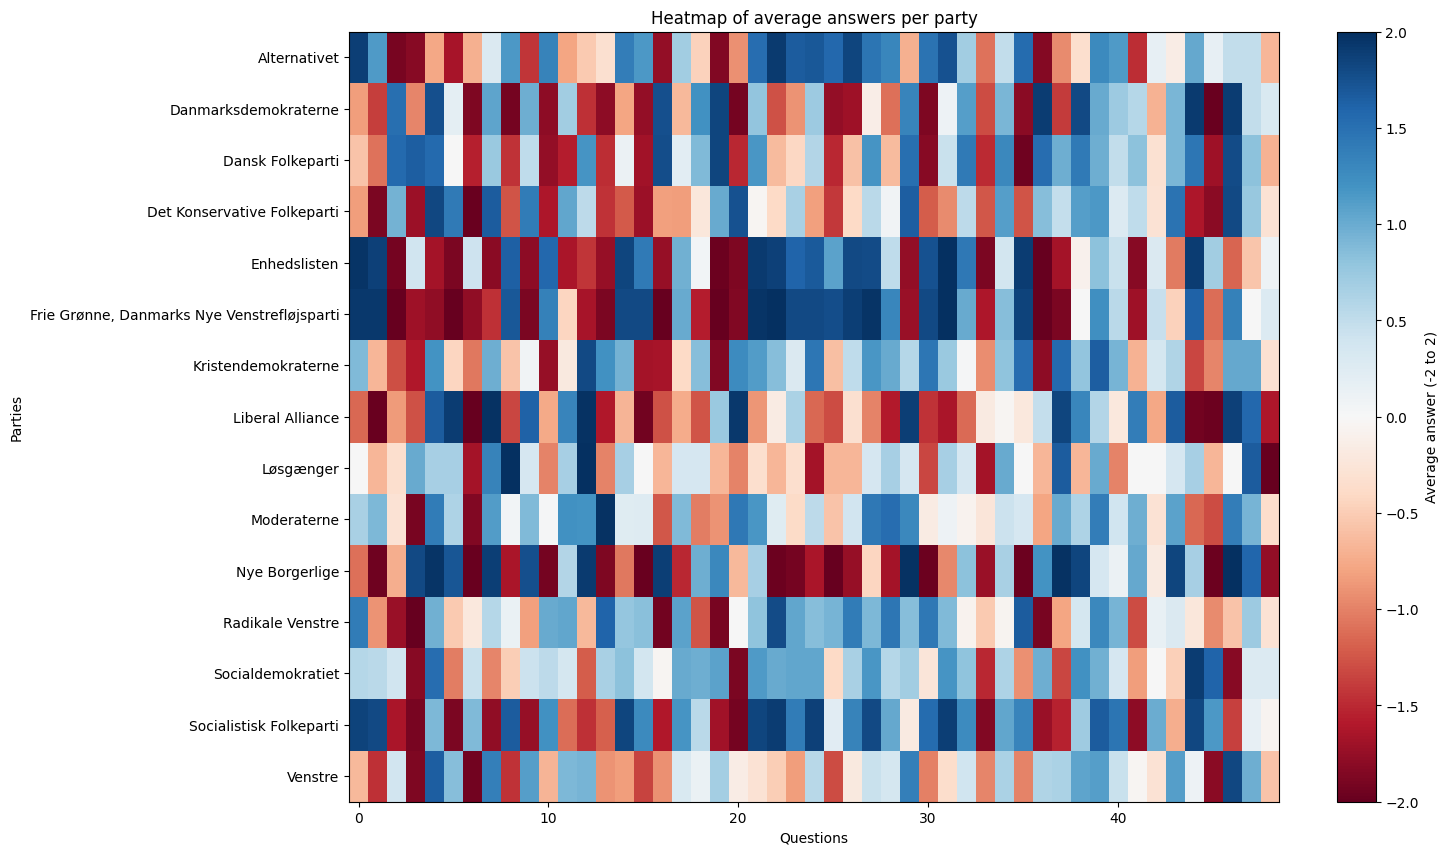

In [3]:
# INTER-PARTY ANALYSE: Heatmap over gennemsnitlige svar for hvert parti pr. spørgsmål
# Gruppér data efter parti og beregn gennemsnit for hvert spørgsmål (axis=0 svarer til pr. kolonne)
party_means = alldata.groupby('parti')[question_cols].mean()

# Visualisering af gennemsnitssvar i heatmap
plt.figure(figsize=(15,10))  # Størrelsen på figuren
plt.imshow(party_means, cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
plt.colorbar(label='Average answer (-2 to 2)')  # Farveskala forklaring
plt.yticks(ticks=np.arange(len(party_means.index)), labels=party_means.index)

plt.title('Heatmap of average answers per party')
plt.xlabel('Questions')
plt.ylabel('Parties')
plt.show()

### Heatmap-fortolkning: Gennemsnitlige svar pr. parti og spørgsmål

Heatmappet viser gennemsnittet af kandidaternes svar inden for hvert parti på tværs af alle spørgsmål.

- Røde felter = gennemsnitligt *uenige* holdninger (mod -2).
- Blå felter = gennemsnitligt *enige* holdninger (mod +2).
- Hvide felter = gennemsnit tæt på neutral (0).

**Eksempler:**
- *Enhedslisten* og *Frie Grønne* har generelt mange mørkerøde felter, hvilket indikerer mere kritiske og venstreorienterede holdninger.
- *Dansk Folkeparti* og *Nye Borgerlige* har mange blå felter, der indikerer mere positive og konservative svar.
- *Venstre* og *Socialdemokratiet* har mange neutrale/hvide felter, hvilket tyder på mere moderate holdninger.

Heatmappet er især nyttigt til hurtigt at identificere hvilke spørgsmål, der skiller partierne mest ideologisk.


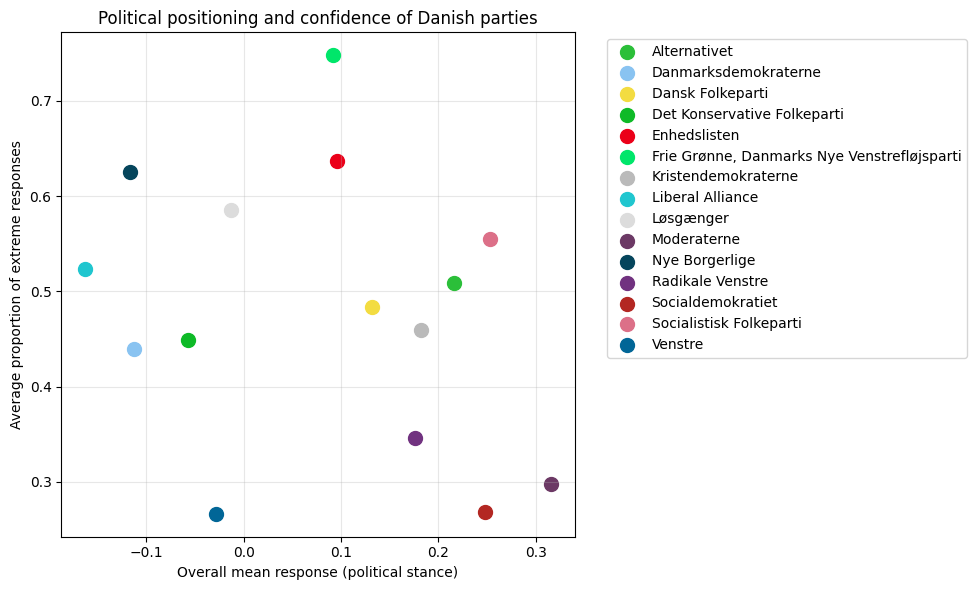

In [4]:
# Beregner partiernes gennemsnitlige holdning (x-akse) og andel ekstreme svar (y-akse)
party_overall_mean = alldata.groupby('parti')[question_cols].mean().mean(axis=1)
party_extreme_ratio = alldata.groupby('parti')[question_cols].apply(
    lambda df: df.isin([-2, 2]).mean(axis=1).mean()
)

# Visualisering: scatterplot
plt.figure(figsize=(10,6))
for parti in party_overall_mean.index:
    plt.scatter(party_overall_mean[parti],
                party_extreme_ratio[parti],
                color=parties_w_color.get(parti, "#555555"),
                label=parti,
                s=100)

plt.xlabel('Overall mean response (political stance)')
plt.ylabel('Average proportion of extreme responses')
plt.title('Political positioning and confidence of Danish parties')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Tolkning af scatterplot – *Political positioning and confidence of Danish parties*

Dette scatterplot viser, hvordan de danske partier placerer sig politisk (x-akse) og hvor ekstreme deres kandidater typisk svarer (y-akse):

- **X-akse (politisk gennemsnit):**
  - Lav værdi (til venstre): Kandidaterne har generelt mere **kritiske eller uenige** holdninger.
  - Høj værdi (til højre): Kandidaterne har generelt mere **positive eller enige** holdninger.

- **Y-akse (andel ekstreme svar):**
  - Høj værdi: Partiets kandidater vælger ofte **"meget enig"/"meget uenig"**, hvilket indikerer **stærke eller selvsikre holdninger**.
  - Lav værdi: Kandidaterne vælger oftere **moderate svar** ("enig"/"uenig"), hvilket tyder på **mere afbalancerede holdninger**.

#### Eksempler:
- **Alternativet** har både **høj x- og y-værdi** → partiet ligger til højre og svarer ofte ekstremt.
- **Venstre** og **Socialdemokratiet** har **relativt lave y-værdier**, hvilket tyder på **mere moderate og konsistente svar**.
- **Enhedslisten** og **Frie Grønne** ligger til venstre og har **meget høj y-værdi**, dvs. partierne har **markante og konsekvente holdninger**.

---

### Stikord til eksamensforklaring (scatterplot)

- **Scatterplot**: Punktdiagram, der visualiserer to numeriske dimensioner.
- **Hver prik**: Et parti, opsummeret på gennemsnit af kandidaters svar.
- **X-akse**: Gennemsnitligt politisk standpunkt (fra -2 til +2).
- **Y-akse**: Gennemsnitlig andel ekstreme svar (-2 eller +2).
- **Fortolkning**:
  - Høj x, lav y → enig, men moderat.
  - Lav x, høj y → uenig og ekstrem.
- **Fordel**: Giver et hurtigt visuelt overblik over ideologisk placering og "selvsikkerhed".
- **Begrænsning**: Gennemsnit kan skjule interne uenigheder → bør suppleres med f.eks. standardafvigelse.



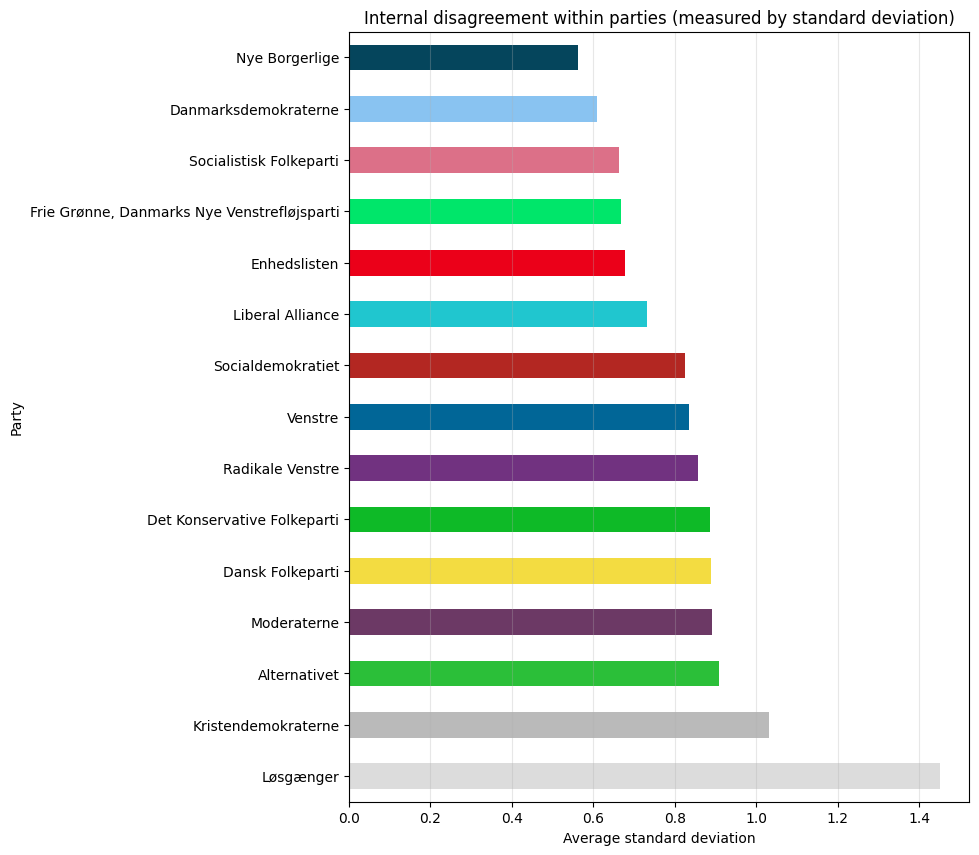

In [5]:
# INTERN UENIGHED: Hvor enige er kandidaterne i hvert parti?
# Standardafvigelse på hvert spørgsmål måler hvor meget kandidaternes svar afviger internt
party_std = alldata.groupby('parti')[question_cols].std()
party_std_mean = party_std.mean(axis=1).sort_values(ascending=False)  # gennemsnit pr. parti

# Barplot over gennemsnitlig intern uenighed
plt.figure(figsize=(8,10))
party_std_mean.plot.barh(color=[parties_w_color.get(p, "#777777") for p in party_std_mean.index])
plt.title('Internal disagreement within parties (measured by standard deviation)')
plt.xlabel('Average standard deviation')
plt.ylabel('Party')
plt.grid(axis='x', alpha=0.3)
plt.show()

### Intern uenighed i partier (standardafvigelse)

Dette søjlediagram viser graden af **intern uenighed** i de danske partier, målt som gennemsnitlig standardafvigelse af kandidaternes svar inden for hvert parti.

- **X-akse**: Gennemsnitlig standardafvigelse i kandidatsvarene.
  - Lav standardafvigelse = kandidaterne svarer relativt ensartet → høj grad af enighed.
  - Høj standardafvigelse = kandidaterne har stor spredning i svar → lav grad af intern enighed.

#### Centrale observationer:
- **Løsgængere** har den **højeste uenighed** (ca. 1.6), hvilket giver mening, da de ikke repræsenterer et samlet parti, men individuelle holdninger.
- **Kristendemokraterne** og **Dansk Folkeparti** udviser også relativt stor intern variation.
- **Nye Borgerlige**, **Danmarksdemokraterne**, og **Socialistisk Folkeparti** har **lavest standardafvigelse**, hvilket indikerer **høj konsistens og intern enighed** blandt kandidaterne.
- De fleste partier ligger mellem 0.8 og 1.1 – en **moderat spredning**, hvilket er forventeligt i bredt sammensatte partier.

---

### Stikord til forklaring af barplot og standardafvigelse

- **Barplot** (søjlediagram) bruges til at sammenligne værdier mellem kategorier (her: partier).
- **Standardafvigelse**: Et mål for, hvor meget svarene varierer omkring gennemsnittet.
  - Lav værdi: Kandidater svarer ens (homogenitet).
  - Høj værdi: Kandidater er uenige (heterogenitet).
- **Fortolkning**:
  - Kan give indsigt i, hvorvidt partiet fremstår som ideologisk samlet eller fragmenteret.
  - Supplerer heatmap og scatterplot ved at fokusere **udelukkende på intern variation** fremfor ideologisk position.

### Samlet konklusion

Analyserne viser tydelige politiske forskelle både **mellem partier** og **internt i partierne**.

Ved at kombinere gennemsnitssvar, andel ekstreme svar og intern variation (standardafvigelse), får vi et samlet overblik over:
- Hvilke partier placerer sig tydeligt ideologisk,
- Hvilke partier har stærk intern sammenhæng,
- Og hvor uenigheden er størst – både mellem og inden for partier.

Tilsammen giver det et nuanceret billede af den politiske landskab i Danmark.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Forudsigelse af kandidaters partitilhørsforhold med klassifikationsmodeller

# Forbereder data: features (holdningssvar) og target (partitilhørsforhold)
X = alldata[question_cols]             # Features: svar på politiske spørgsmål
y = alldata['parti']                   # Target: hvilket parti kandidaten tilhører

# Deler data i trænings- og testdata (70/30) med stratificering for balance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialiserer modeller: Decision Tree, Random Forest og Gradient Boosted Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gbt_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Træner modellerne på træningsdata
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gbt_model.fit(X_train, y_train)

# Laver forudsigelser på testdata
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbt = gbt_model.predict(X_test)

# Evaluerer modellernes nøjagtighed (accuracy) og detaljeret klassifikationsrapport
# Accuracy: Hvor stor andel forudsigelser er korrekte
# Klassifikationsrapport: Precision, Recall og F1-score per parti
from sklearn.metrics import accuracy_score, classification_report

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Gradient Boosted Tree Accuracy:", accuracy_score(y_test, y_pred_gbt))

print("\nDecision Tree Report:\n", classification_report(y_test, y_pred_dt, zero_division=0))
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("\nGradient Boosted Tree Report:\n", classification_report(y_test, y_pred_gbt, zero_division=0))

Decision Tree Accuracy: 0.7624521072796935
Random Forest Accuracy: 0.9233716475095786
Gradient Boosted Tree Accuracy: 0.8467432950191571

Decision Tree Report:
                                              precision    recall  f1-score   support

                               Alternativet       0.59      0.65      0.62        20
                       Danmarksdemokraterne       0.83      0.91      0.87        11
                           Dansk Folkeparti       0.92      0.80      0.86        15
                Det Konservative Folkeparti       0.72      0.70      0.71        30
                               Enhedslisten       0.81      0.95      0.88        22
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.71      0.62      0.67         8
                        Kristendemokraterne       1.00      0.46      0.63        13
                           Liberal Alliance       0.73      0.90      0.81        21
                                  Løsgænger       0.00      0.00      0.0

## Model performance summary: Predicting party affiliation

### Overordnet nøjagtighed
- **Random Forest** havde den højeste præcision med **91.2% accuracy**.
- **Gradient Boosted Tree** klarede sig godt med **83.1% accuracy**, men havde mere svingende resultater mellem partier.
- **Decision Tree** klarede sig dårligst med kun **76.2% accuracy** – modellen er simpel og overfitter let.

---

### Precision, Recall og F1-score – samlet vurdering

#### Random Forest
- **Høj præcision og recall** på næsten alle partier – især *Socialdemokratiet*, *Radikale Venstre*, *Nye Borgerlige* og *Moderaterne*.
- **Både præcision og recall > 0.9** for mange partier → lav fejlrate.
- **Høj F1-score (0.91 weighted avg)** viser god balance mellem korrekt klassifikation og undgåelse af fejl.
- Bemærk: *Løsgængere* blev ikke korrekt klassificeret (support = 1 → svært for modellen at lære).

#### Gradient Boosted Tree
- Mere **svingende resultater** – gode scores for fx *Socialdemokratiet* og *Dansk Folkeparti*, men lav **recall for små partier** som *Frie Grønne*.
- Gennemsnitlig præcision: **0.84**, recall: **0.76**, F1-score: **0.83**.
- Mindre stabil på ubalancerede data → kræver justeringer for at konkurrere med Random Forest.

#### Decision Tree
- **Lav præcision og recall** generelt.
- Svag ydeevne for partier som *Løsgængere* og *Liberal Alliance* (F1 = 0.00).
- Simpel model → **mange fejlklassifikationer**, især på tværs af ideologisk lignende partier.

---

### Konklusion
- Random Forest er klart bedst – stabil, præcis og balanceret.
- Gradient Boosted Tree er et stærkt alternativ, men kræver tuning ved ubalancerede datasæt.
- Decision Tree er for simpel og giver for mange fejl – ikke anbefalet til denne type opgave.



In [7]:
# Identificering af kandidater, som blev forudsagt til et andet parti end deres faktiske

# 1. Genskaber testdatasættet med navn og rigtige partier
# Vi tager udgangspunkt i de samme kandidater, som var i testdatasættet (X_test/y_test)
alldata_test = alldata.iloc[y_test.index].copy()

# 2. Tilføjer modellens (Random Forest) forudsagte partier til datasættet
# Vi tilføjer de prædikterede partier som en ny kolonne
alldata_test['predicted_party'] = y_pred_rf  # vi bruger Random Forest da den havde bedst præcision

# 3. Filtrerer de kandidater, hvor modellen har forudsagt forkert parti
# Det gøres ved at sammenligne 'parti' (faktisk parti) med 'predicted_party' (forudsagt)
misclassified = alldata_test[alldata_test['parti'] != alldata_test['predicted_party']]

# 4. Viser kun de relevante kolonner: kandidatens navn, rigtige parti og forudsagte parti
display(misclassified[['navn', 'parti', 'predicted_party']])


,navn,parti,predicted_party
8,Chresten H. Ibsen,Løsgænger,Radikale Venstre
15,Rasmus Bøgh Vinther,Enhedslisten,Alternativet
519,Kasper B. Mundt,Venstre,Nye Borgerlige
139,Linea Søgaard-Lidell,Venstre,Det Konservative Folkeparti
823,Esben Frette Johnsen,Kristendemokraterne,Radikale Venstre
816,Lars Prier,Dansk Folkeparti,Det Konservative Folkeparti
42,Ali Khatib,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet
43,Sara Hvidbak Grouleff,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet
433,Rishi Balachandran,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Enhedslisten
326,Diana-Ester Eriksen,Det Konservative Folkeparti,Dansk Folkeparti


### Misclassified Candidates – Analysis

Nedenstående tabel viser de kandidater, hvor **Random Forest-modellen** har forudsagt et andet parti end kandidatens faktiske tilhørsforhold. Dette giver os indsigt i, hvilke partier og kandidater der har et atypisk svarmønster.

#### Typiske mønstre og fejlkilder:

- **Ideologisk overlap mellem partier:**
  - *Frie Grønne*-kandidater blev ofte klassificeret som *Alternativet* eller *Enhedslisten*. Disse partier deler grønne og venstreorienterede mærkesager, hvilket gør dem vanskelige at skelne i modellen.
  - Flere *Venstre*-kandidater blev forvekslet med *Det Konservative Folkeparti* og *Nye Borgerlige*, hvilket kan skyldes et tæt politisk ståsted i borgerlige spørgsmål.
  - *Kristendemokraterne* blev ofte forvekslet med *Radikale Venstre*, hvilket tyder på midterplacering og svarmønstre, der ikke er klart højre- eller venstreorienterede.

- **Tydelige enkeltsager:**
  - *Nicklas Gjedsig Larsen* (Alternativet → Socialdemokratiet): Tyder på, at hans svar var mere moderate eller pragmatiske end partiets typiske profil.
  - *Nikoline Prehn* (Socialdemokratiet → Socialistisk Folkeparti): Afspejler muligvis en mere venstreorienteret svarprofil, hvilket kan være i overensstemmelse med partiernes historiske alliance.

---

### Overall Conclusion (Classification task)

- **Random Forest** leverede den bedste balance mellem præcision og robusthed og blev derfor valgt til fejlklassifikationsanalysen.
- De fleste fejl sker mellem **ideologisk nært beslægtede partier**, hvilket er forventeligt i et fløjspolitisk landskab.
- Enkelte kandidater kan være mere *centrerede* eller *yderligtgående* end deres partilinje, hvilket forklarer forvekslingen.
- **Machine Learning** viser sig at være en nyttig metode til at analysere og vurdere **politisk konsistens og partiaffinitet** ud fra holdningsdata.
